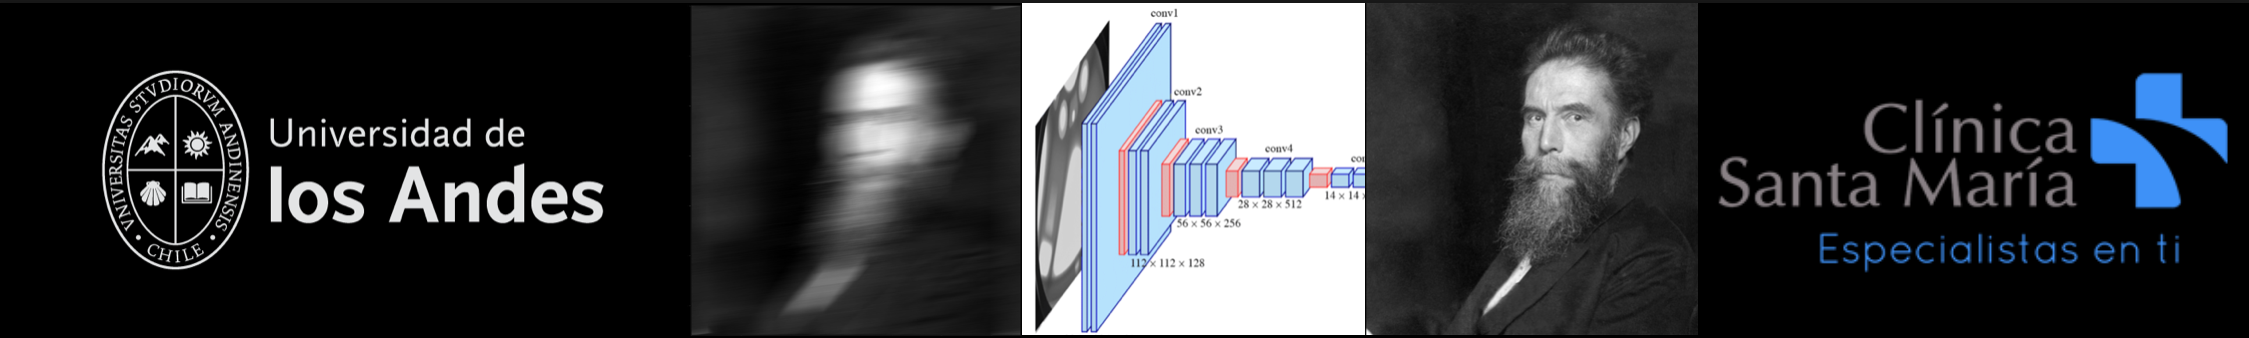

* Autor: Dr. Héctor Henríquez Leighton
* e-mail: hhenriquez@miuandes.cl

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from tqdm import trange
import requests
import json 

## Descarga de token de kaggle que permite acceder al set de datos
json_response= requests.get("https://raw.githubusercontent.com/HectorHenriquez/Motion-Artifact-Reduction-Model/main/kaggle.json")

token = json.loads(json_response.text)
with open("kaggle.json", "w") as outfile:
    json.dump(token, outfile)

## Carga de datos desde Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Dataset
! kaggle datasets download hshenriquez/motion-artifact-chest-ct-images

!unzip /content/motion-artifact-chest-ct-images.zip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
motion-artifact-chest-ct-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/motion-artifact-chest-ct-images.zip
  inflating: Motion Artifact Reduction Model.ipynb  
  inflating: modelosinusoidal256.h5  
  inflating: sample_test_256.npy     


In [2]:
def show_slice_window(slice, level, window):
    
    """
    input: imagen array 2D, 
    permite ajustar ventana y nivel para mejorar contraste de la imagen.
    output: imagen array 2D ventaneada.
   """
    
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)

In [3]:
def ssim_fx(y_test, prediccion):
    
    ssim_none = ssim(y_test, prediccion, data_range=y_test.max() - y_test.min(),
                 multichannel=True)
    return(ssim_none)

In [9]:
## Carga de las imágenes: Tensor de 2048 imagenes, con resolución de 256 x 256 pixeles.
## Tiene 2 canales: El primero corresponde a la imagen original y el segundo la imagen degradada.
## Imagenes normalizadas

test_images = np.load('/content/sample_test_256.npy')

print("Dimensiones:", test_images.shape)

Dimensiones: (2048, 256, 256, 2)


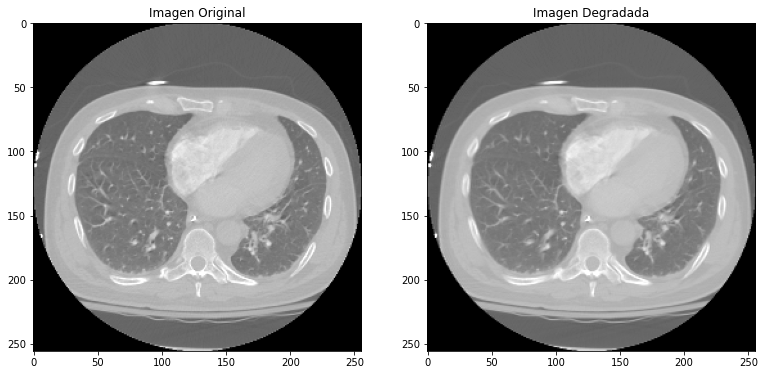

In [11]:

## Viualización de bionomio de imagenes
index = np.random.randint(0, test_images.shape[0])

## Ajuste de ventana
level = 0.2
window_width = 2.8

f = plt.figure(figsize=(20,20), frameon=False)

f.add_subplot(1, 3, 1)
plt.title("Imagen Original")
plt.imshow(show_slice_window((test_images[index,:,:,0]).reshape(256,256),level,window_width), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title("Imagen Degradada")
plt.imshow(show_slice_window((test_images[index,:,:,1]).reshape(256,256), level, window_width), cmap='gray')


### Aplicación de Modelo de reconstrucción

In [12]:
## Se carga el modelo pre-entrenado.        
model = load_model('/content/modelosinusoidal256.h5')
print(model.summary())

Caso número: 392
1/1 [==============================] - 2s 2s/step
************************************************************
Cálculo de métricas:

SSIM imagen degradada: 0.823
SSIM predicción:  0.927
Mejoría en SSIM: 60.5 %
MSE imagen degradada: 0.0121
MSE predicción: 0.0025
Reducción MSE:79.13 %


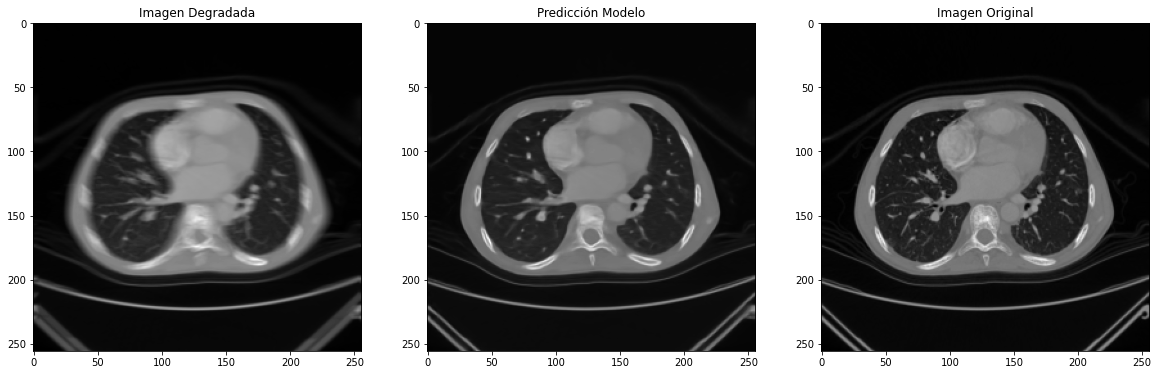

In [16]:
## Se elige una imagen aleatoria y se reconstruye con Modelo pre-entrenado

numero = np.random.randint(0,test_images.shape[0])

print("Caso número:", numero)

## Ventaneo
level = 0.8
window_width = 2.5

img_target = test_images[numero,:,:,0]
#print(img_target.shape)

img_artifact = test_images[numero,:,:,1]
#print(img_artifact.shape)
img_tensor = np.expand_dims(img_artifact, axis=0) 

prediccion = model.predict(img_tensor)
prediccion = prediccion.reshape(256,256)
#print(prediccion.shape)

print("***" *20)
print("Cálculo de métricas:\n")
print("SSIM imagen degradada:", round(ssim_fx(img_target, img_artifact),3))
print("SSIM predicción: ", round(ssim_fx(prediccion,img_target ),3) )
print("Mejoría en SSIM: {} %".format(round((round(ssim_fx(prediccion, img_target),3) - round(ssim_fx(img_artifact, img_target),3)) / (1-round(ssim_fx(img_artifact, img_target),3)),3)*100))
print("MSE imagen degradada:", round(mean_squared_error(img_artifact,img_target),4))
print("MSE predicción:", round(mean_squared_error(prediccion,img_target),4))
print("Reducción MSE:{} %".format(round((mean_squared_error(img_artifact,img_target) - mean_squared_error(prediccion,img_target)) /mean_squared_error(img_artifact,img_target)*100,2)))

f = plt.figure(figsize=(20,20))
f.add_subplot(1, 3, 1)
plt.title('Imagen Degradada')
plt.imshow(show_slice_window(test_images[numero,:,:,1],level,window_width), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title('Predicción Modelo')
plt.imshow(show_slice_window(prediccion,level,window_width), cmap='gray')

f.add_subplot(1, 3, 3)
plt.title('Imagen Original')
plt.imshow(show_slice_window(test_images[numero,:,:,0],level,window_width), cmap='gray')
plt.show()